In [38]:
import torch
import torchvision
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.datasets import MNIST
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn

In [39]:
mnist = MNIST(root = './', 
                train = True,
                transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
                )

In [40]:
img, label = mnist[5]
# print(img)
print(label)

2


In [41]:
def denorm(x):
    out = (x+1) / 2
    return out.clamp(0 , 1)

Label: 2


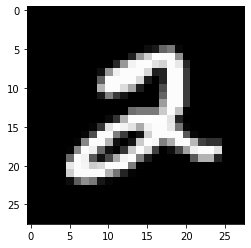

In [42]:
%matplotlib inline
denorm(img)
plt.imshow(img[0], cmap = 'gray')
print('Label:', label)

In [43]:
data_batch = DataLoader(dataset = mnist,
                            batch_size = 100,
                            shuffle = True)

torch.Size([100, 1, 28, 28])
tensor([1, 5, 2, 6, 8, 3, 7, 0, 6, 7, 8, 8, 3, 8, 4, 5, 4, 5, 6, 3, 1, 4, 0, 6,
        6, 6, 2, 9, 1, 7, 6, 7, 5, 1, 9, 2, 6, 3, 4, 1, 8, 7, 8, 8, 6, 9, 5, 6,
        8, 9, 2, 3, 7, 8, 4, 4, 8, 3, 8, 3, 0, 2, 4, 8, 1, 8, 3, 5, 8, 7, 3, 4,
        8, 9, 3, 6, 5, 5, 3, 5, 6, 4, 3, 1, 2, 3, 9, 5, 6, 4, 4, 5, 9, 7, 8, 5,
        4, 7, 1, 0])


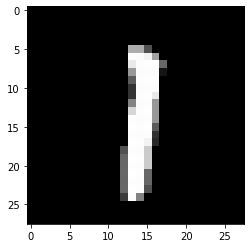

In [44]:
for img, label in data_batch:
    print(img.shape)
    # print(img[0][0])
    plt.imshow(img[0][0], cmap = 'gray')
    print(label)
    break

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
device

device(type='cpu')

In [47]:
image_size = 784
hidden_state = 256

In [48]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_state),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_state, hidden_state),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_state, 1),
    nn.Sigmoid()
)

In [49]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [50]:
latent_size = 128

In [51]:
G = nn.Sequential(
        nn.Linear(latent_size, hidden_state),
        nn.ReLU(),
        nn.Linear(hidden_state, hidden_state),
        nn.ReLU(),
        nn.Linear(hidden_state, image_size),
        nn.Tanh()
)

In [52]:
G.to(device)

Sequential(
  (0): Linear(in_features=128, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

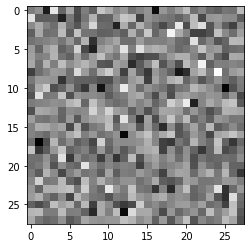

In [53]:
y = G(torch.randn(3, latent_size))
generated_imgs = denorm(y.reshape((-1, 28,28)).detach())
plt.imshow(generated_imgs[0], cmap = 'gray')

In [54]:
loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)